# standardization of product name
1. 목표
  - 다양한 노이즈가 포함된 상품명 표준화(feature는 오로지 상품명)
  - ex) 왕족발+막국수, 2인 족 set, 족발세트, 족발(앞다리) => 족발

1. 현황
 - 각 상품명에 라벨이 붙어있지만, 100% 신뢰할 수는 없음
 - Tfidf-NB 이용하여 accuracy 85~90% (이것 또한 신뢰도가 떨어짐)
 - 오타에 대한 단어장을 전부 만들 수 없음(단어장에 없으면 형태소 추출불가)
 
2. FastText
 - Subword representation
 - 하나의 단어를 bag of character n-grams 로 표현
     - 어디야 => bigram <어디, 디야> *한국어는 이걸론 부족함*
     - => trigram+자모분해 <ㅇㅓㄷ, ㅓㄷㅣ,ㄷㅣㅇ,ㅣㅇㅑ>
     
3. 적용
  - text+label=>자모분리=>FastText
     1. CNN or RNN => 분류 
     1. 클러스터링 => 대표메뉴 추출 (현재는 rule-base labeling이 되어 있음)

https://lovit.github.io/nlp/representation/2018/10/22/fasttext_subword/#more
https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb

In [1]:
import re
import sys
import numpy as np

kor_begin     = 44032
kor_end       = 55203
chosung_base  = 588
jungsung_base = 28
jaum_begin = 12593
jaum_end = 12622
moum_begin = 12623
moum_end = 12643

chosung_list = [ 'ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 
        'ㅅ', 'ㅆ', 'ㅇ' , 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

jungsung_list = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 
        'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 
        'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 
        'ㅡ', 'ㅢ', 'ㅣ']

jongsung_list = [
    ' ', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ',
        'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 
        'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 
        'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

jaum_list = ['ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄸ', 'ㄹ', 
              'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 
              'ㅃ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

moum_list = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 
              'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']

doublespace_pattern = re.compile('\s+')

def decompose(c):
    if not character_is_korean(c):
        return None
    i = to_base(c)
    if (jaum_begin <= i <= jaum_end):
        return (c, ' ', ' ')
    if (moum_begin <= i <= moum_end):
        return (' ', c, ' ')    
    i -= kor_begin
    cho  = i // chosung_base
    jung = ( i - cho * chosung_base ) // jungsung_base 
    jong = ( i - cho * chosung_base - jung * jungsung_base )    
    return (chosung_list[cho], jungsung_list[jung], jongsung_list[jong])

def character_is_complete_korean(c):
    return (kor_begin <= to_base(c) <= kor_end)

def character_is_korean(c):
    i = to_base(c)
    return (kor_begin <= i <= kor_end) or (jaum_begin <= i <= jaum_end) or (moum_begin <= i <= moum_end)

def character_is_number(i):
    i = to_base(i)
    return (i >= 48 and i <= 57)

def character_is_english(i):
    i = to_base(i)
    return (i >= 97 and i <= 122) or (i >= 65 and i <= 90)

def to_base(c):
    if sys.version_info.major == 2:
        if type(c) == str or type(c) == unicode:
            return ord(c)
        else:
            raise TypeError
    else:
        if type(c) == str or type(c) == int:
            return ord(c)
        else:
            raise TypeError
            
def jamo_sentence(sent):

    def transform(char):
        if char == ' ': # 영어, 숫자, 띄어쓰기는 그대로
            return char
        elif character_is_english(char) or character_is_number(char):
            return char
        elif not character_is_complete_korean(char): # 숫자, 자음,모음만있는 경우 제거
            cjj = ''
        else:
            cjj = decompose(char)
                                    # 종성이 없는 경우 _로 대체
        cjj_ = ''.join('_' if c == ' ' else c for c in cjj) 
        return cjj_

    sent_ = ''.join(transform(char) for char in sent)
    sent_ = doublespace_pattern.sub(' ', sent_)
    return sent_

jamo_sentence('ice 아메리카노 빅사이즈 3000원 ㅎㅋㅋ')

'ice ㅇㅏ_ㅁㅔ_ㄹㅣ_ㅋㅏ_ㄴㅗ_ ㅂㅣㄱㅅㅏ_ㅇㅣ_ㅈㅡ_ 3000ㅇㅝㄴ '

In [2]:
from gensim.models import FastText
from gensim.test.utils import common_texts

test = [('짜장', 0), ('사천 짜장면', 0), ('백짬뽕', 0), ('ice 아메리카노', 1), 
        ('아이스아메리', 1),  ('짜장면', 0), ('짜파게티', 0), ('아메리카노 커피', 1), 
        ('커피', 1), ('자장면', 0), ('아메리치노', 1), ('americano (iced)', 1)] 

df = pd.DataFrame(test, columns=['text', 'label'])

df['jamo'] = df.text.apply(lambda x: [(jamo_sentence(j)) for j in x.split(" ")])

model_ = FastText(df.jamo.apply(lambda x: [' '.join(x)]), size=10, window=4, min_count=1, iter=10)

# df['jamo'] = df.text.apply(lambda x: jamo_sentence(x))
# model_ = FastText([x for x in df.jamo], size=150, window=4, min_count=1, iter=10)

- 

In [3]:
model_.wv.most_similar(jamo_sentence("짬+짜+탕"))

model_[jamo_sentence("사천 짜장")] # out-of-vocab 도 벡터로 변환 (subword 있다면)

/home/mk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-0.00904142,  0.0249215 ,  0.00444178, -0.01067573, -0.00333797,
        0.00302149,  0.00926554, -0.00010484,  0.01754159, -0.00915419],
      dtype=float32)

## set data

In [4]:
from keras.utils import np_utils

x = model_[df.jamo.apply(lambda x: ' '.join(x))][:, :, np.newaxis]
y_ = df.label.values#[:, np.newaxis]

y = np_utils.to_categorical(y_, 2)

train_x = x[:6]
train_y = y[:6]

val_x = x[6:]
val_y = y[6:]

x.shape, y.shape

Using TensorFlow backend.
/home/mk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


((12, 10, 1), (12, 2))

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()
model.add(LSTM(128, input_shape =(10, 1)))

model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x, y, validation_data=(val_x, val_y), epochs=600, verbose=2)

Train on 12 samples, validate on 6 samples
Epoch 1/600
 - 3s - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6936 - val_acc: 0.3333
Epoch 2/600
 - 0s - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6915 - val_acc: 0.6667
Epoch 3/600
 - 0s - loss: 0.6930 - acc: 0.5000 - val_loss: 0.6925 - val_acc: 0.6667
Epoch 4/600
 - 0s - loss: 0.6929 - acc: 0.5000 - val_loss: 0.6937 - val_acc: 0.3333
Epoch 5/600
 - 0s - loss: 0.6929 - acc: 0.5000 - val_loss: 0.6937 - val_acc: 0.3333
Epoch 6/600
 - 0s - loss: 0.6928 - acc: 0.5000 - val_loss: 0.6928 - val_acc: 0.6667
Epoch 7/600
 - 0s - loss: 0.6927 - acc: 0.7500 - val_loss: 0.6917 - val_acc: 0.6667
Epoch 8/600
 - 0s - loss: 0.6926 - acc: 0.5000 - val_loss: 0.6913 - val_acc: 0.6667
Epoch 9/600
 - 0s - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6918 - val_acc: 0.8333
Epoch 10/600
 - 0s - loss: 0.6924 - acc: 0.6667 - val_loss: 0.6926 - val_acc: 0.6667
Epoch 11/600
 - 0s - loss: 0.6923 - acc: 0.7500 - val_loss: 0.6929 - val_acc: 0.3333
Epoch 12/600
 - 0s - loss: 0.69

Epoch 97/600
 - 0s - loss: 0.6199 - acc: 0.6667 - val_loss: 0.6722 - val_acc: 0.5000
Epoch 98/600
 - 0s - loss: 0.6154 - acc: 0.6667 - val_loss: 0.6869 - val_acc: 0.6667
Epoch 99/600
 - 0s - loss: 0.6132 - acc: 0.6667 - val_loss: 0.6564 - val_acc: 0.3333
Epoch 100/600
 - 0s - loss: 0.6167 - acc: 0.5833 - val_loss: 0.7132 - val_acc: 0.5000
Epoch 101/600
 - 0s - loss: 0.6305 - acc: 0.5833 - val_loss: 0.6738 - val_acc: 0.6667
Epoch 102/600
 - 0s - loss: 0.6180 - acc: 0.6667 - val_loss: 0.5959 - val_acc: 0.6667
Epoch 103/600
 - 0s - loss: 0.5939 - acc: 0.7500 - val_loss: 0.5964 - val_acc: 0.5000
Epoch 104/600
 - 0s - loss: 0.6282 - acc: 0.5833 - val_loss: 0.6069 - val_acc: 0.8333
Epoch 105/600
 - 0s - loss: 0.5947 - acc: 0.8333 - val_loss: 0.6350 - val_acc: 0.6667
Epoch 106/600
 - 0s - loss: 0.6115 - acc: 0.6667 - val_loss: 0.6267 - val_acc: 0.6667
Epoch 107/600
 - 0s - loss: 0.6091 - acc: 0.6667 - val_loss: 0.5980 - val_acc: 0.8333
Epoch 108/600
 - 0s - loss: 0.5949 - acc: 0.8333 - val_lo

Epoch 193/600
 - 0s - loss: 0.3484 - acc: 0.8333 - val_loss: 0.3404 - val_acc: 0.8333
Epoch 194/600
 - 0s - loss: 0.3084 - acc: 0.9167 - val_loss: 0.3444 - val_acc: 0.8333
Epoch 195/600
 - 0s - loss: 0.3056 - acc: 0.9167 - val_loss: 0.3563 - val_acc: 0.6667
Epoch 196/600
 - 0s - loss: 0.3178 - acc: 0.8333 - val_loss: 0.3554 - val_acc: 0.6667
Epoch 197/600
 - 0s - loss: 0.3198 - acc: 0.7500 - val_loss: 0.3366 - val_acc: 0.8333
Epoch 198/600
 - 0s - loss: 0.3045 - acc: 0.8333 - val_loss: 0.3123 - val_acc: 0.8333
Epoch 199/600
 - 0s - loss: 0.2834 - acc: 0.9167 - val_loss: 0.2997 - val_acc: 0.8333
Epoch 200/600
 - 0s - loss: 0.2734 - acc: 0.9167 - val_loss: 0.3028 - val_acc: 0.8333
Epoch 201/600
 - 0s - loss: 0.2736 - acc: 0.8333 - val_loss: 0.3115 - val_acc: 0.8333
Epoch 202/600
 - 0s - loss: 0.2622 - acc: 0.9167 - val_loss: 0.3240 - val_acc: 0.8333
Epoch 203/600
 - 0s - loss: 0.2399 - acc: 0.9167 - val_loss: 0.3544 - val_acc: 0.6667
Epoch 204/600
 - 0s - loss: 0.2375 - acc: 0.8333 - val

Epoch 289/600
 - 0s - loss: 0.1467 - acc: 0.9167 - val_loss: 0.2626 - val_acc: 0.8333
Epoch 290/600
 - 0s - loss: 0.1455 - acc: 0.9167 - val_loss: 0.2405 - val_acc: 0.8333
Epoch 291/600
 - 0s - loss: 0.1388 - acc: 0.9167 - val_loss: 0.1901 - val_acc: 1.0000
Epoch 292/600
 - 0s - loss: 0.1260 - acc: 1.0000 - val_loss: 0.1477 - val_acc: 1.0000
Epoch 293/600
 - 0s - loss: 0.1432 - acc: 1.0000 - val_loss: 0.1495 - val_acc: 1.0000
Epoch 294/600
 - 0s - loss: 0.1528 - acc: 0.9167 - val_loss: 0.2092 - val_acc: 0.8333
Epoch 295/600
 - 0s - loss: 0.1757 - acc: 0.8333 - val_loss: 0.2604 - val_acc: 0.8333
Epoch 296/600
 - 0s - loss: 0.3170 - acc: 0.8333 - val_loss: 0.3972 - val_acc: 0.8333
Epoch 297/600
 - 0s - loss: 0.6795 - acc: 0.7500 - val_loss: 0.2061 - val_acc: 0.8333
Epoch 298/600
 - 0s - loss: 0.4370 - acc: 0.8333 - val_loss: 0.1483 - val_acc: 1.0000
Epoch 299/600
 - 0s - loss: 0.2913 - acc: 0.8333 - val_loss: 0.1753 - val_acc: 0.8333
Epoch 300/600
 - 0s - loss: 0.3327 - acc: 0.8333 - val

Epoch 385/600
 - 0s - loss: 0.0555 - acc: 1.0000 - val_loss: 0.0763 - val_acc: 1.0000
Epoch 386/600
 - 0s - loss: 0.0548 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 1.0000
Epoch 387/600
 - 0s - loss: 0.0543 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 1.0000
Epoch 388/600
 - 0s - loss: 0.0536 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 1.0000
Epoch 389/600
 - 0s - loss: 0.0528 - acc: 1.0000 - val_loss: 0.0737 - val_acc: 1.0000
Epoch 390/600
 - 0s - loss: 0.0521 - acc: 1.0000 - val_loss: 0.0713 - val_acc: 1.0000
Epoch 391/600
 - 0s - loss: 0.0514 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 1.0000
Epoch 392/600
 - 0s - loss: 0.0509 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 1.0000
Epoch 393/600
 - 0s - loss: 0.0503 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 1.0000
Epoch 394/600
 - 0s - loss: 0.0495 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 1.0000
Epoch 395/600
 - 0s - loss: 0.0489 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 1.0000
Epoch 396/600
 - 0s - loss: 0.0484 - acc: 1.0000 - val

Epoch 481/600
 - 0s - loss: 0.0195 - acc: 1.0000 - val_loss: 0.0263 - val_acc: 1.0000
Epoch 482/600
 - 0s - loss: 0.0194 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 1.0000
Epoch 483/600
 - 0s - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 1.0000
Epoch 484/600
 - 0s - loss: 0.0190 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 1.0000
Epoch 485/600
 - 0s - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 1.0000
Epoch 486/600
 - 0s - loss: 0.0187 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 1.0000
Epoch 487/600
 - 0s - loss: 0.0185 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 488/600
 - 0s - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 489/600
 - 0s - loss: 0.0182 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 1.0000
Epoch 490/600
 - 0s - loss: 0.0181 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 1.0000
Epoch 491/600
 - 0s - loss: 0.0180 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 1.0000
Epoch 492/600
 - 0s - loss: 0.0178 - acc: 1.0000 - val

Epoch 577/600
 - 0s - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 578/600
 - 0s - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 1.0000
Epoch 579/600
 - 0s - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 580/600
 - 0s - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 1.0000
Epoch 581/600
 - 0s - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 582/600
 - 0s - loss: 0.0092 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 583/600
 - 0s - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 584/600
 - 0s - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 585/600
 - 0s - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 586/600
 - 0s - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 1.0000
Epoch 587/600
 - 0s - loss: 0.0089 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 1.0000
Epoch 588/600
 - 0s - loss: 0.0089 - acc: 1.0000 - val

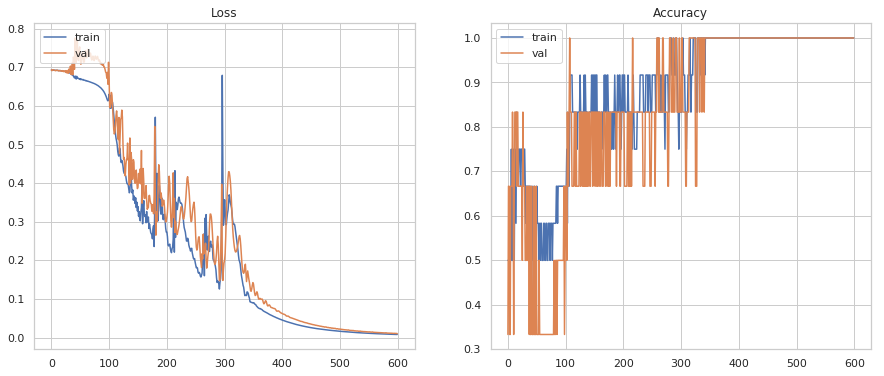

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
# plt.figure(figsize=(12, 12))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()